# SELICRD Model

S - susceptable, E - exposed, L - latent, I - infected, C - critical, R - recovered, D - dead

Following:
https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

![title](model.jpg)

In [265]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import matplotlib.dates as mdates
base_dir = 'Data'

First, we define the system of differential equations modelling the flow between compartments

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \beta  S \dfrac{I + L}{N}\\
\dfrac{\delta E}{\delta t} &= \beta  S \dfrac{I + L}{N} - \delta  E\\
\dfrac{\delta L}{\delta t} &= \delta  E - \epsilon  p_{L\rightarrow R}  L - \theta  (1 - p_{L\rightarrow R})  L\\
\dfrac{\delta I}{\delta t} &= \theta  (1 - p_{L\rightarrow R})  L - \gamma  (1 - p_{I\rightarrow C})  I  -\lambda  p_{I\rightarrow C}  I\\
\dfrac{\delta C}{\delta t} &= \lambda p_{I\rightarrow C}  I - \tau  \cdot (1 - p_{C\rightarrow D})  \cdot min(beds(t), C) - 
\rho  \cdot p_{C\rightarrow D}  \cdot \min(beds(t), C) - \max(0, C - beds(t))\\
\dfrac{\delta R}{\delta t} &= \gamma  (1 - p_{I\rightarrow R})  I + \tau  (1 - p_{C\rightarrow D})  \cdot \min(beds(t), C) + \epsilon  p_{L\rightarrow R}  L\\
\dfrac{\delta D}{\delta t} &= \rho  \cdot p_{C\rightarrow D}  \cdot min(beds(t), C) + max(0, C-beds(t))
\end{align*}$$

In [266]:
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    dSdt = -beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

We can model the declining R0 as a logistical interpolation as "Stay at Home" orders are released and followed. 

In [267]:
# def logistic_R_0(t, R_0_start, k, x0, R_0_end):
#     if -k*(-t+x0) >= 500: return R_0_end
#     return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
def R0_t(t, b, r_s):
    return (2 / np.pi) * np.arctan(-(t - b) / 10 * r_s) + 1.0

We can find the numerical solution to the ODEs 

In [268]:
# def Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#     # infection rate comes from current R0
#     def beta(t):
#         return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
#     # model bed usage in the poplation
#     def beds(t):
#         beds_0 = beds_per_10k / 10_000 * N
#         return beds_0 + s*beds_0*t  # 0.003
#     # run model
#     N = sum(agegroups)
#     y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
#     t = np.linspace(0, days, days)
#     ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
#     S, E, L, I, C, R, D = ret.T
#     R_0_over_time = [beta(i)/gamma for i in range(len(t))]
#     return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D
def Model(days, agegroups, beds_per_100k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
    def beta(t):
        return alpha*R0_t(t, b, r_s)
    N = sum(agegroups)
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, Beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/alpha for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, Beds, p_I_to_C, p_C_to_D

In [203]:
def plotter(t, S, E, L, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None: 
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax.title.set_text('SELICRD Model')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

Next, define the hyper-parameter rates of the model

In [204]:
gamma = 1.0 / 17.5 # 9 days from infection to recovery
delta = 1.0 / 2.5  # incubation period of four days
epsilon = 1.0 / 14.0 # two weeks for latent person to recover
theta = 1.0 /2.0 # three days for latent to show symptoms
lamda = 1.0 / 11.0 # five days for infected to be critical
tau = 1.0 / 11.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death

## Parameter Fitting

In [205]:
# params_init_min_max = {"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), "p_L_to_R": (0.6, 0.0, 0.8),
#                        "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
#                        "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

params_init_min_max = {#"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), 
                       "p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (0.3, 0.1, 5.7), 
                       "b": (20, 0, 40), "r_s": (1, 0.1, 10),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}


In [206]:
def run_and_plot(country, outbreak_shift):
    #deaths
    if country == 'China': 
        deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
        # rename the column header so that it is same as other data
        deaths.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
    else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    
    deaths = deaths[deaths.country == country]
    
    # find the case when equal or more than 100 infection cases detected
    deaths = deaths.loc[deaths["cases_ttl"].values>=100]
    data = deaths["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else: y_data = data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    
    # fit model to deaths
#     def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#         ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
#         return ret[7][x]
    def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
        ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
        return ret[7][x]
    mod = lmfit.Model(fitter)
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    params = mod.make_params()
    fit_method = "leastsq"
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    print(result.best_values)
    print(np.mean(result.residual **2))
    
    # forward predict
    dates = deaths["date"].values
    first_date = dates[0]
    full_days = len(y_data) + 30
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    predict_range = full_days - len(y_data)
    forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
    death_projection = forecast[7]
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label="Data")
    ax.plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
    ax.plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")
    label_idx = np.arange(0, len(x_ticks), 15)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(death_projection))
    label_location = location[label_idx]; ax.set_xticks(label_location)
    ax.set_xticklabels(labels, rotation=45); ax.set_ylabel("Deaths")
    ax.set_title(country) ;ax.legend() ;fig.autofmt_xdate(); plt.show()

    # plot 
    full_days = 500 ## let's predict full 200 days
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    print("Prediction for " + country)
    plotter(*Model(full_days, agegroups, beds_per_10k, **result.best_values), x_ticks=x_ticks);

## United States

{'alpha': 0.9950212430480356, 'b': 19.61029906228056, 'r_s': 9.71509605589545, 'p_L_to_R': 0.4725678612896453, 'p_I_to_C': 0.0767636573405645, 'p_C_to_D': 0.7999999999991659, 's': 0.0032642200267284645}
531549.5760216785


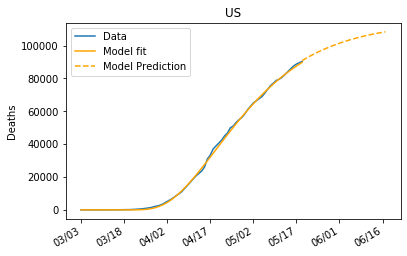

Prediction for US
percentage going to ICU: 7.676365734056451; percentage dying in ICU: 79.9999999999166


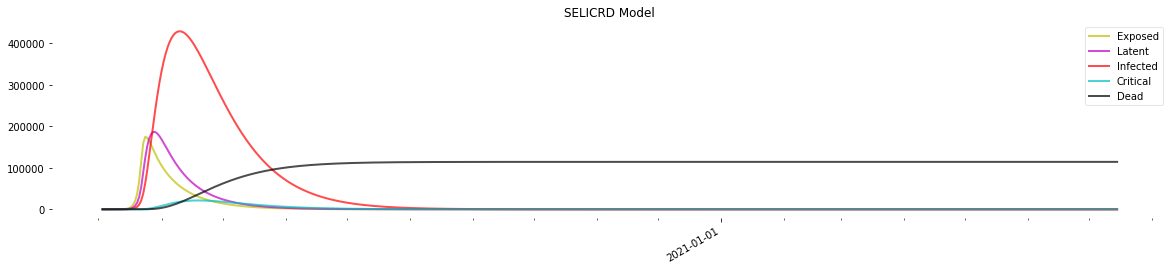

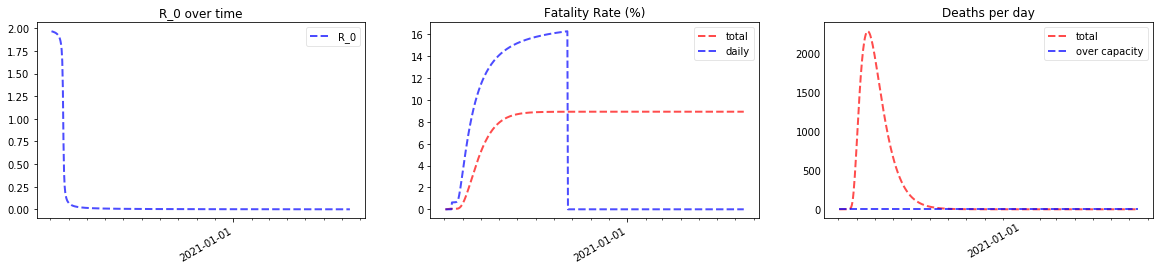

In [207]:
run_and_plot("US", 0)

## China

{'alpha': 0.6553512142700131, 'b': 25.83909289536213, 'r_s': 1.3884815314662802, 'p_L_to_R': 0.799991074901342, 'p_I_to_C': 0.001000144878604717, 'p_C_to_D': 0.3887487059646078, 's': 0.003}
111244.19976682548


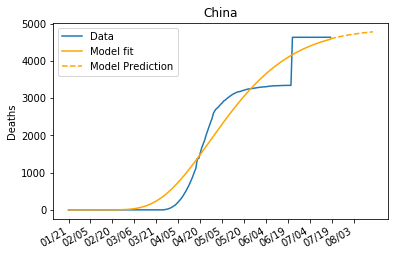

Prediction for China
percentage going to ICU: 0.1000144878604717; percentage dying in ICU: 38.87487059646078


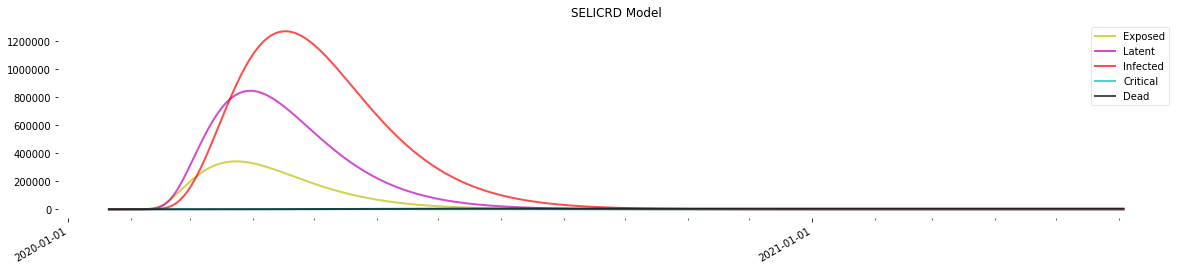

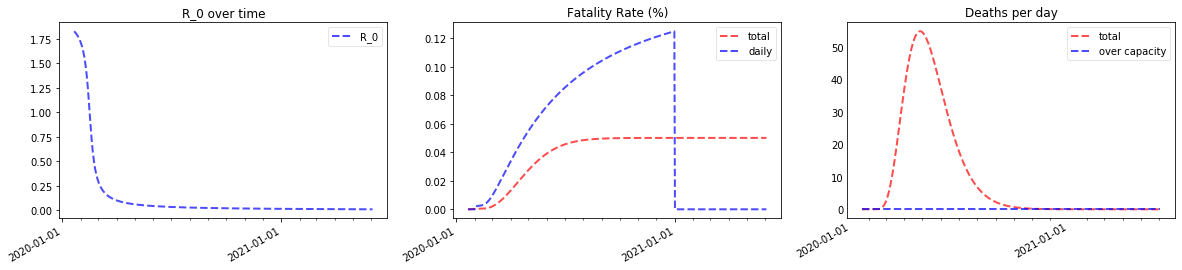

In [208]:
run_and_plot("China", 65)

## Brazil

{'alpha': 5.413622489578989, 'b': 3.4357675847549825, 'r_s': 9.999999552884692, 'p_L_to_R': 9.712295813427313e-12, 'p_I_to_C': 0.09999999670654132, 'p_C_to_D': 0.7999999999999998, 's': 0.003}
59830.44663338261


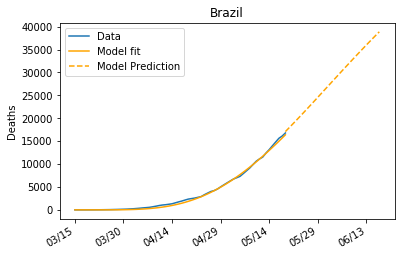

Prediction for Brazil
percentage going to ICU: 9.999999670654132; percentage dying in ICU: 79.99999999999999


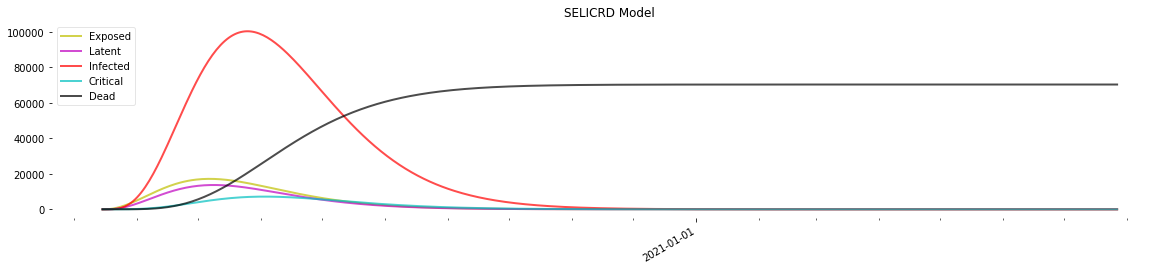

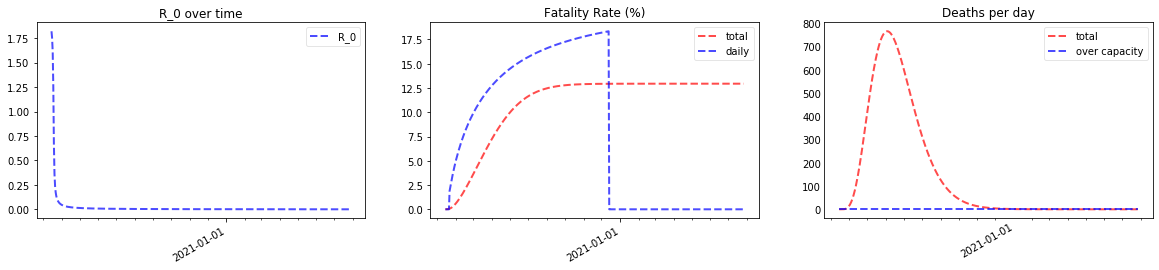

In [209]:
run_and_plot("Brazil", 0)

## India

{'alpha': 4.40169675353165, 'b': 3.4997421668451523, 'r_s': 9.999974259585613, 'p_L_to_R': 3.159787720577996e-06, 'p_I_to_C': 0.09999997727411462, 'p_C_to_D': 0.7999998438997514, 's': 0.003}
3255.0249142712946


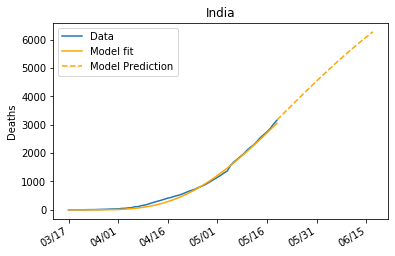

Prediction for India
percentage going to ICU: 9.999997727411463; percentage dying in ICU: 79.99998438997514


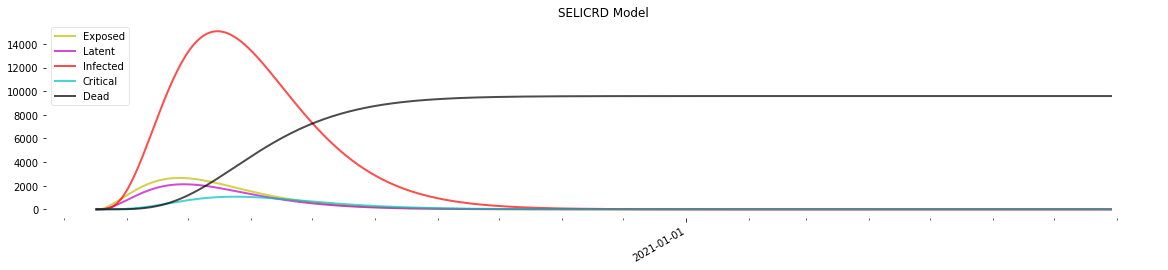

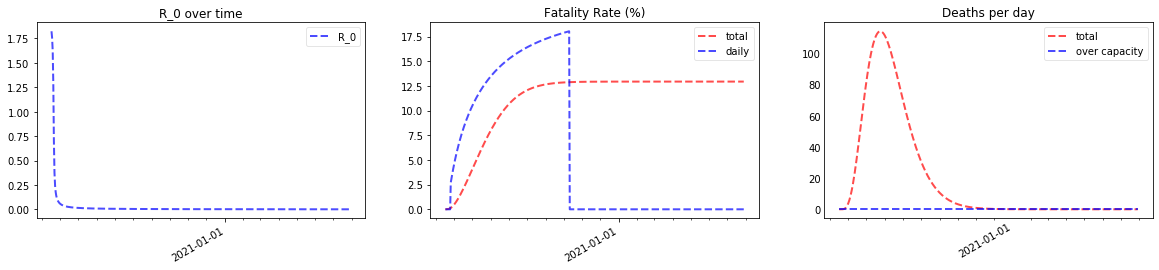

In [210]:
run_and_plot("India", 0)

## Germany

{'alpha': 0.6257880161471865, 'b': 21.347392253121136, 'r_s': 9.999977101083223, 'p_L_to_R': 1.625808725737897e-05, 'p_I_to_C': 0.09999999998041653, 'p_C_to_D': 0.7999999069972528, 's': 0.003}
4766.03057977509


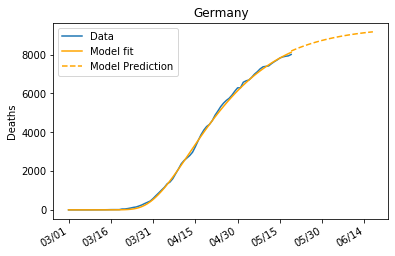

Prediction for Germany
percentage going to ICU: 9.999999998041654; percentage dying in ICU: 79.99999069972527


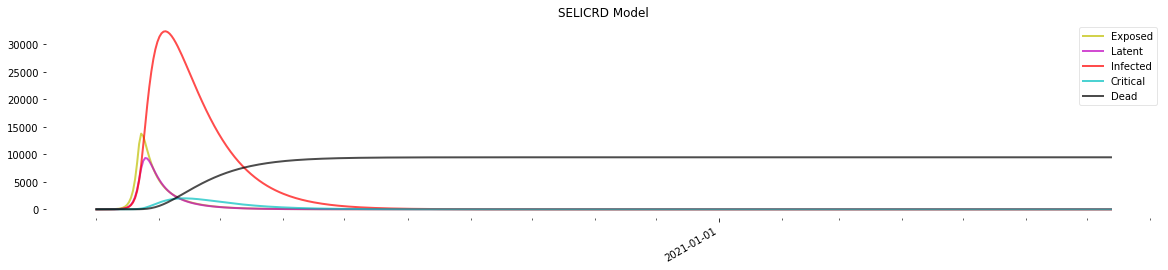

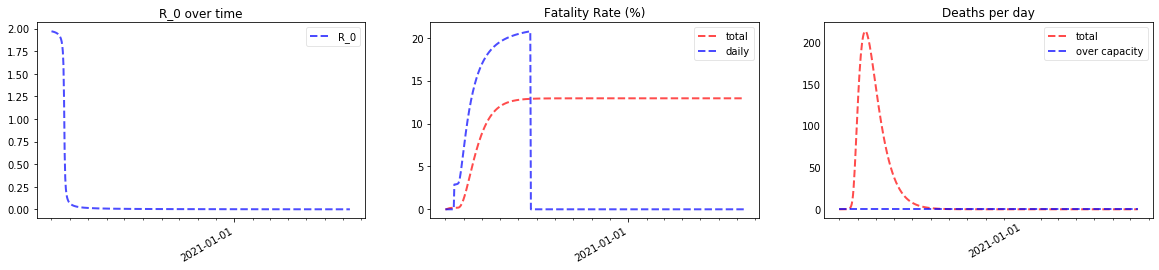

In [211]:
run_and_plot("Germany", 0)

## Italy

{'alpha': 1.3329512873420168, 'b': 13.911424801346296, 'r_s': 9.999999969088892, 'p_L_to_R': 1.7549006695977384e-10, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999999996, 's': 0.0041271437609907095}
4538714.791652384


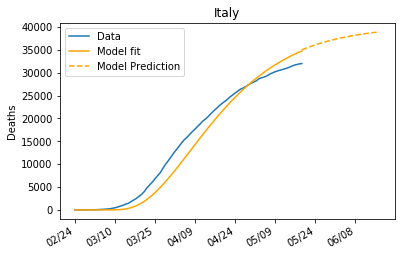

Prediction for Italy
percentage going to ICU: 10.0; percentage dying in ICU: 79.99999999999996


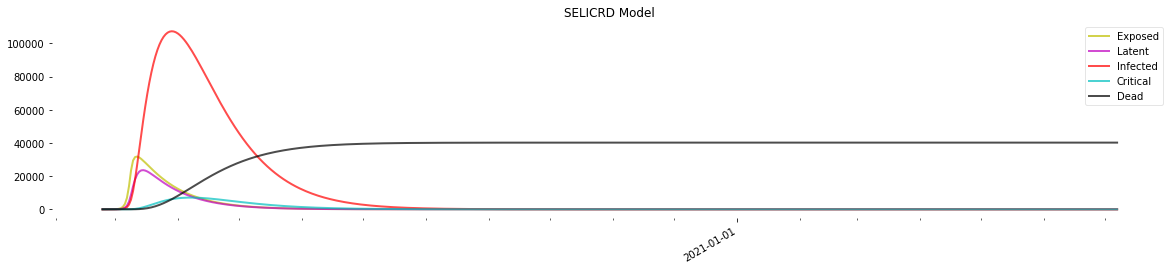

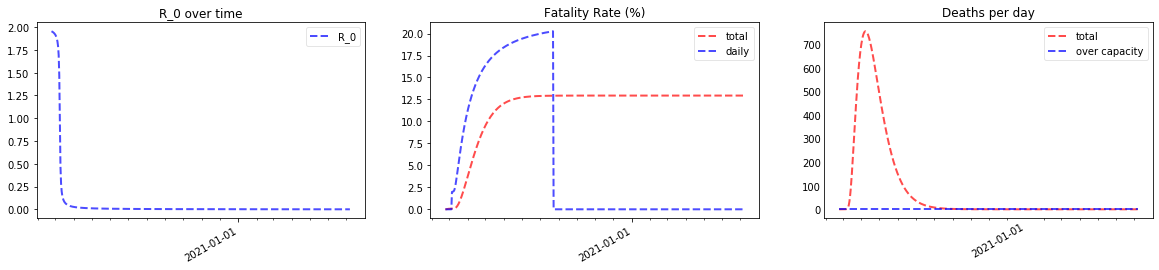

In [212]:
run_and_plot("Italy", 0)

## Spain

{'alpha': 1.382328124481557, 'b': 13.534458506298913, 'r_s': 9.999999929218317, 'p_L_to_R': 3.5127261896149295e-12, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999871306, 's': 0.003980767928368459}
9281549.06062955


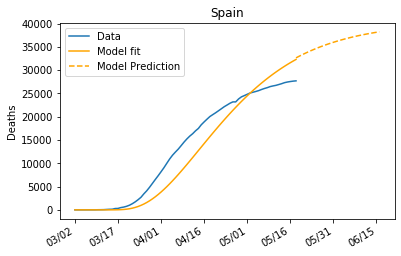

Prediction for Spain
percentage going to ICU: 10.0; percentage dying in ICU: 79.99999999871305


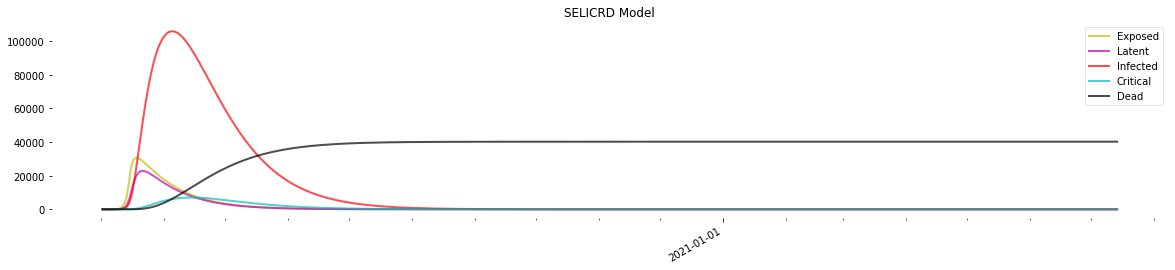

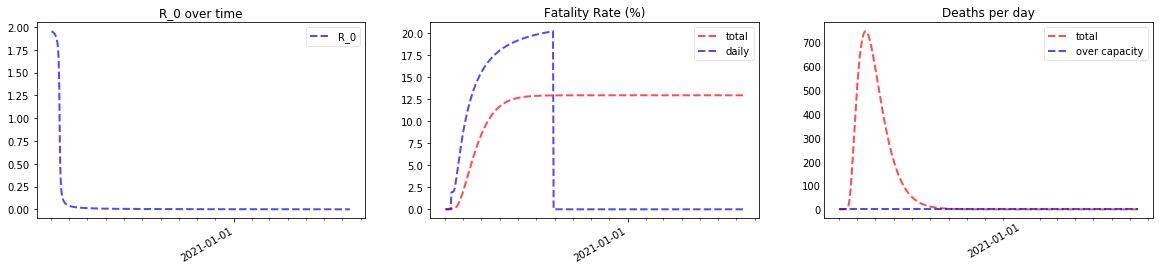

In [213]:
run_and_plot("Spain", 0)

## United Kingdom

{'alpha': 1.354644860912029, 'b': 13.94062135525994, 'r_s': 9.999999999279114, 'p_L_to_R': 2.100989251233794e-09, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999998561431, 's': 0.009818906577500251}
1056396.4745889814


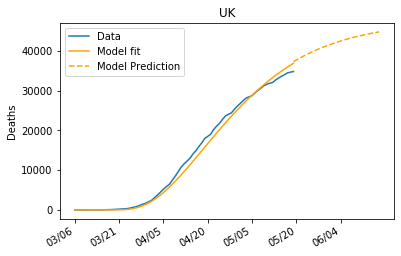

Prediction for UK
percentage going to ICU: 10.0; percentage dying in ICU: 79.99999998561431


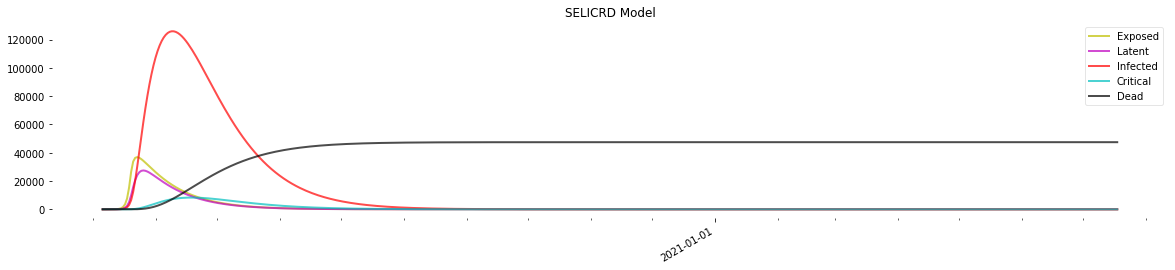

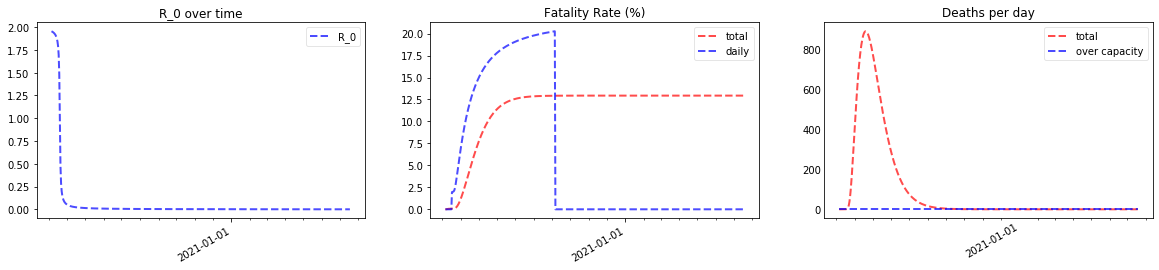

In [214]:
run_and_plot("UK", 0)

## France

{'alpha': 1.2091748859935973, 'b': 14.863178755713921, 'r_s': 9.99999999665195, 'p_L_to_R': 2.037576700181515e-08, 'p_I_to_C': 0.09999999999998262, 'p_C_to_D': 0.7999999999746612, 's': 0.003}
2203414.914297655


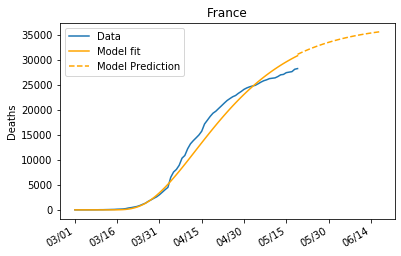

Prediction for France
percentage going to ICU: 9.999999999998261; percentage dying in ICU: 79.99999999746612


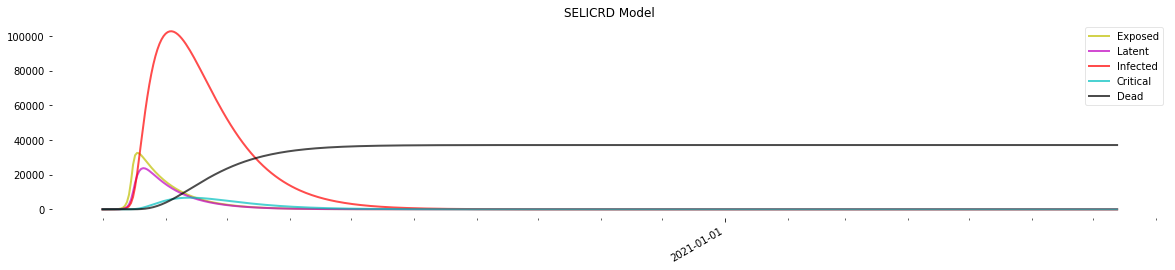

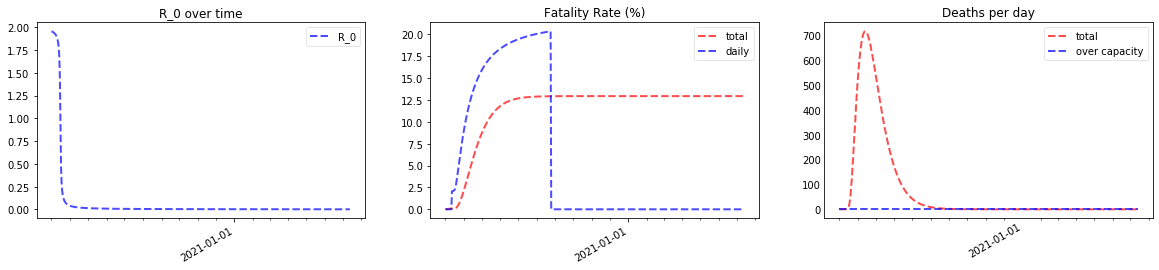

In [215]:
run_and_plot("France", 0)

## Canada

{'alpha': 1.7585343545940304, 'b': 10.163351873650395, 'r_s': 7.8394901351184005, 'p_L_to_R': 0.7999999999769605, 'p_I_to_C': 0.09999999996367853, 'p_C_to_D': 0.7999999562275885, 's': 0.003}
1266.7662051603909


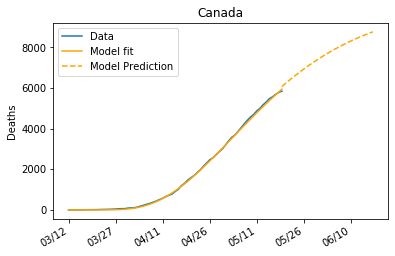

Prediction for Canada
percentage going to ICU: 9.999999996367853; percentage dying in ICU: 79.99999562275885


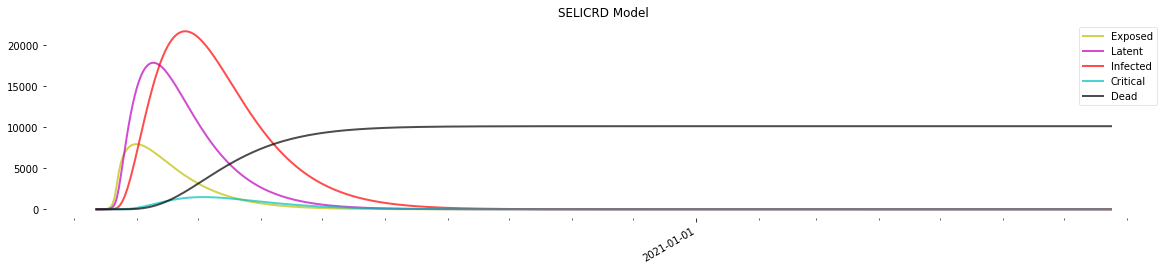

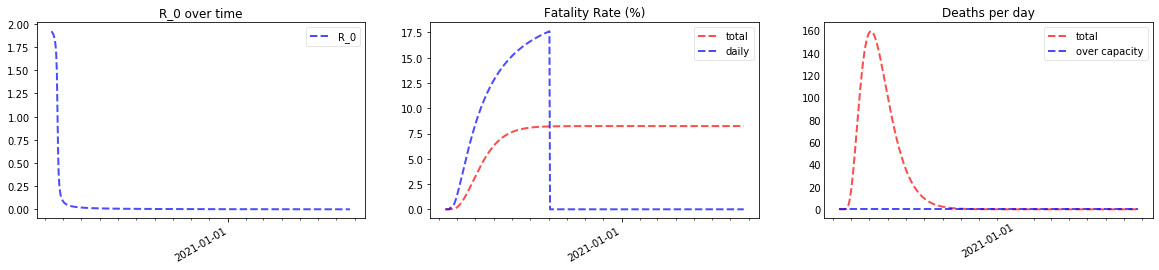

In [216]:
run_and_plot("Canada", 0)

## Netherlands

{'alpha': 1.2981696005943077, 'b': 12.227849618689586, 'r_s': 9.999999947491384, 'p_L_to_R': 9.71052883939358e-11, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999088344, 's': 0.003310704205342213}
219740.15166866855


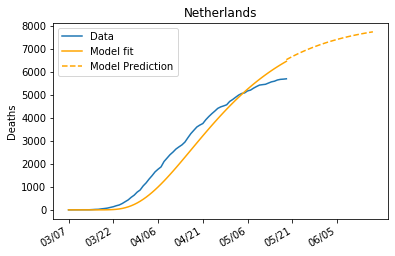

Prediction for Netherlands
percentage going to ICU: 10.0; percentage dying in ICU: 79.99999999088344


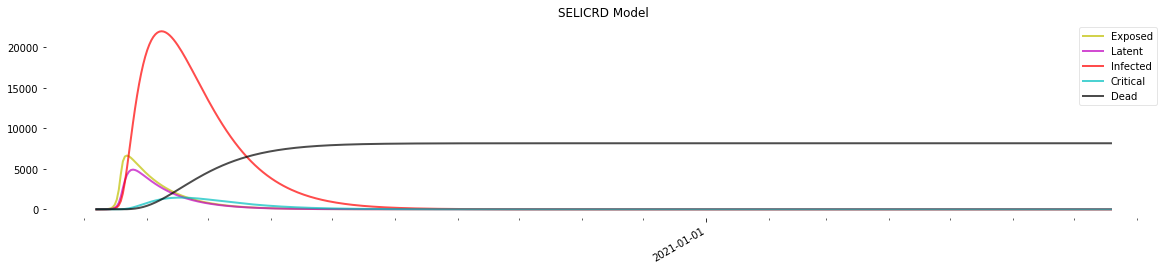

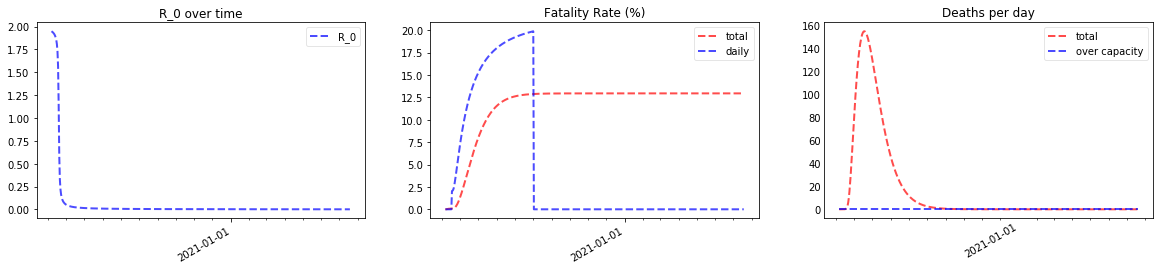

In [217]:
run_and_plot("Netherlands", 0)

# Validation

In [302]:
from sklearn.model_selection import train_test_split

def Validate(country):
    outbreak_shift = 0
    
    if country == 'China': 
        deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
        # rename the column header so that it is same as other data
        deaths.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
    else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    
    deaths = deaths[deaths.country == country]

    # find the case when equal or more than 100 infection cases detected
    deaths = deaths.loc[deaths["cases_ttl"].values>=100]
    data = deaths["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else: y_data = data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array


    # This represents test size to be the last 30%, 20% and 10% of data
    test_sizes = [0.3, 0.2, 0.1] 

    param_vec = []
    test_errors = []
    train_errors = []

    for test_size in test_sizes:
        print(test_size)
        X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle = False) # make sure shuffle is False

        def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
                ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
                return ret[7][x]
        mod = lmfit.Model(fitter)
        for kwarg, (init, mini, maxi) in params_init_min_max.items():
            mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
        params = mod.make_params()
        fit_method = "leastsq"
        result = mod.fit(Y_train, params, method="least_squares", x=X_train)

        ## store parameter values
        param_vec.append(result.best_values)

        # forward predict
        full_days = len(x_data)
        forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
        death_projection = forecast[7]


        train_error = np.linalg.norm(Y_train - death_projection[:len(Y_train)], 2)
        test_error = np.linalg.norm(Y_test - death_projection[-len(Y_test):], 2)

        print("Train Error: {0}".format( train_error ))
        print("Test Error: {0}".format( test_error ))

        train_errors.append(train_error)
        test_errors.append(test_error)

    best_case = np.argmin(test_errors)
    best_parameters = param_vec[best_case]

    print("Best Validation case is when test size is remaining {0} %".format(test_sizes[best_case]*100))
    
    plt.figure()
    plt.plot((1-np.array(test_sizes)) * 100, test_errors)
    plt.xlabel("Train Set Percentage")
    plt.ylabel(r"$L_2$ Norm Error")
    plt.title("{0} Data Validation".format(country))
    plt.show()
    
    return best_parameters

0.3
Train Error: 4595.356853178084
Test Error: 38225.30254510433
0.2
Train Error: 5692.653274490843
Test Error: 3368.4700053388324
0.1
Train Error: 6063.719766201763
Test Error: 3265.6963721202133
Best Validation case is when test size is remaining 10.0 %


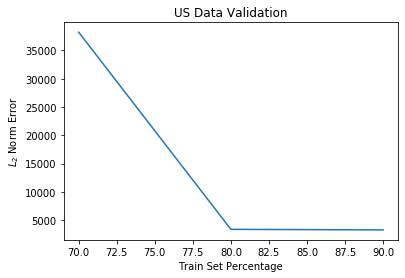

In [303]:
best_param_each_country = dict()

best_param_each_country["US"] = Validate("US")

0.3
Train Error: 7699.7722048982605
Test Error: 3340.6841669976147
0.2
Train Error: 8176.616166482993
Test Error: 576.236537870079
0.1
Train Error: 8190.829960374194
Test Error: 142.64605763068138
Best Validation case is when test size is remaining 10.0 %


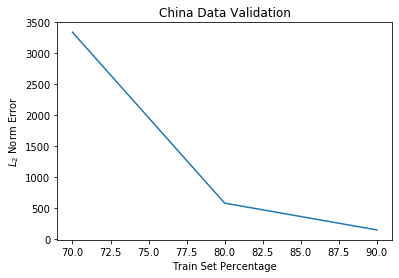

In [304]:
best_param_each_country["China"]  = Validate("China")

0.3
Train Error: 691.2733175224992
Test Error: 15044.57449561806
0.2
Train Error: 978.1413667674161
Test Error: 8186.28649295345
0.1
Train Error: 1488.61047949466
Test Error: 3103.0051331540963
Best Validation case is when test size is remaining 10.0 %


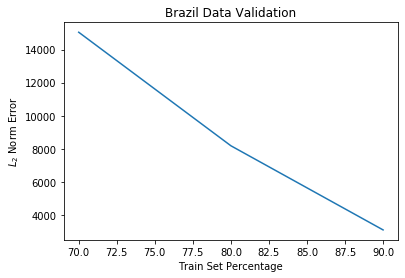

In [305]:
best_param_each_country["Brazil"]  = Validate("Brazil")

0.3
Train Error: 161.2629820127466
Test Error: 2866.1980934253993
0.2
Train Error: 310.9339041974585
Test Error: 1581.7066198786595
0.1
Train Error: 421.69807795825375
Test Error: 393.84246092495
Best Validation case is when test size is remaining 10.0 %


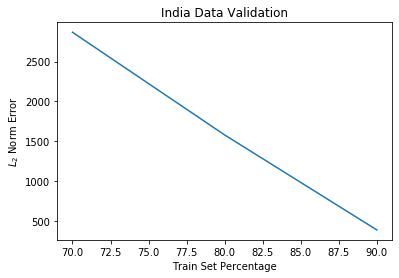

In [306]:
India_best_param = Validate("India")

In [314]:
df

,Name,Value
0,alpha,3.935110e+00
1,b,4.052640e+00
2,r_s,9.999993e+00
3,p_L_to_R,2.470437e-08
4,p_I_to_C,9.999936e-02
5,p_C_to_D,8.000000e-01
6,s,3.000000e-03


0.3
Train Error: 324.35842528865135
Test Error: 3775.1687605500797
0.2
Train Error: 442.3814264443382
Test Error: 1300.8008771762436
0.1
Train Error: 545.5708750339495
Test Error: 491.77303962888925
Best Validation case is when test size is remaining 10.0 %


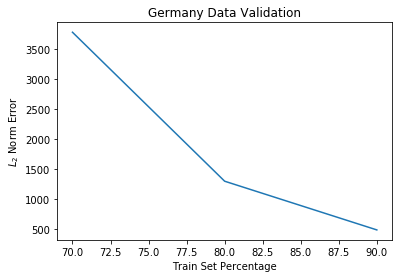

In [307]:
Germany_best_param = Validate("Germany")

0.3
Train Error: 12747.517462627402
Test Error: 37620.264304426826
0.2
Train Error: 15760.197902308582
Test Error: 22859.29571002237
0.1
Train Error: 18653.101553925655
Test Error: 11904.034445330311
Best Validation case is when test size is remaining 10.0 %


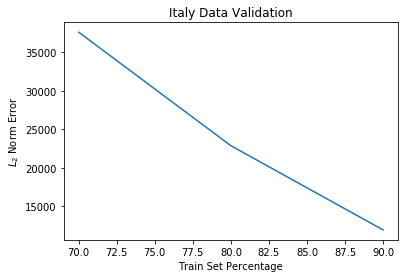

In [308]:
Italy_best_param = Validate("Italy")

In [ ]:
Spain_best_param = Validate("Spain")

In [ ]:
UK_best_param = Validate("UK")

In [ ]:
France_best_param = Validate("France")

In [ ]:
Canada_best_param = Validate("Canada")

In [ ]:
Netherlands_best_param = Validate("Netherlands")

In [326]:
params_total = dict()
params_total["India"] = India_best_param
params_total["Italy"] = Italy_best_param


In [327]:
df = pd.DataFrame(params_total.items())
df

,0,1
0,India,"((alpha, 3.9351101222208715), (b, 4.0526399086..."
1,Italy,"((alpha, 1.4172808718496317), (b, 13.348628509..."


In [332]:
US_best_param.values()

dict_values([0.9208380169310434, 20.17970696023171, 9.999999922555062, 0.3450027923544465, 0.09999999999591896, 0.7999999999806063, 0.0022167671514129626])

In [346]:
# pd.DataFrame(US_best_param.values(), columns=US_best_param.keys())
df = pd.DataFrame([Italy_best_param], columns=Italy_best_param.keys())
df2 = pd.DataFrame([India_best_param], columns=India_best_param.keys())

print(df)
print(df2)

      alpha          b   r_s      p_L_to_R  p_I_to_C  p_C_to_D         s  \
0  1.417281  13.348629  10.0  7.700495e-12       0.1       0.8  0.005067   

  Country  
0   Italy  
     alpha        b       r_s      p_L_to_R  p_I_to_C  p_C_to_D      s Country
0  3.93511  4.05264  9.999993  2.470437e-08  0.099999       0.8  0.003   India


In [350]:
pd.merge(df, df2, how='left', on='Country')

,alpha_x,b_x,r_s_x,p_L_to_R_x,p_I_to_C_x,p_C_to_D_x,s_x,Country,alpha_y,b_y,r_s_y,p_L_to_R_y,p_I_to_C_y,p_C_to_D_y,s_y
0,1.417281,13.348629,10.0,7.700495e-12,0.1,0.8,0.005067,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
India_best_param
df = pd.DataFrame(India_best_param.items())
df.columns = ['Name', 'Value']